##Natural Images Classification

In [2]:
!nvidia-smi

Tue May 18 15:29:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/natural-images.zip"

In [4]:
batch_size = 64
img_height = 124
img_width = 124

In [18]:
import PIL
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/natural_images",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6899 files belonging to 8 classes.
Using 5520 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/natural_images",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6899 files belonging to 8 classes.
Using 1379 files for validation.


In [10]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']


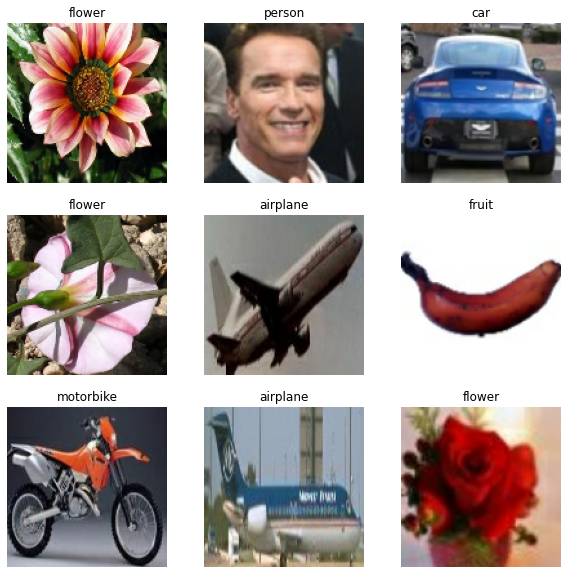

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [14]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(1000, activation='relu'),
  layers.Dense(num_classes)
])

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 124, 124, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 124, 124, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 124, 124, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 64)       

In [19]:
checkpoint = ModelCheckpoint("model_natural_images.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose = 1)

earlystop = EarlyStopping(monitor="val_loss",
                         min_delta=0,
                         patience=3,
                         verbose=1,
                         restore_best_weights=True)

callbacks = [earlystop, checkpoint]

In [21]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callbacks,
)

Epoch 1/50
87/87 [==============================] - 40s 44ms/step - loss: 1.5676 - accuracy: 0.4268 - val_loss: 0.7073 - val_accuracy: 0.7636

Epoch 00001: val_loss improved from inf to 0.70726, saving model to model_natural_images.h5
Epoch 2/50
87/87 [==============================] - 2s 25ms/step - loss: 0.5509 - accuracy: 0.7997 - val_loss: 0.5170 - val_accuracy: 0.8020

Epoch 00002: val_loss improved from 0.70726 to 0.51696, saving model to model_natural_images.h5
Epoch 3/50
87/87 [==============================] - 2s 25ms/step - loss: 0.4848 - accuracy: 0.8180 - val_loss: 0.4880 - val_accuracy: 0.8252

Epoch 00003: val_loss improved from 0.51696 to 0.48803, saving model to model_natural_images.h5
Epoch 4/50
87/87 [==============================] - 2s 25ms/step - loss: 0.3632 - accuracy: 0.8617 - val_loss: 0.3809 - val_accuracy: 0.8666

Epoch 00004: val_loss improved from 0.48803 to 0.38089, saving model to model_natural_images.h5
Epoch 5/50
87/87 [==============================] -

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

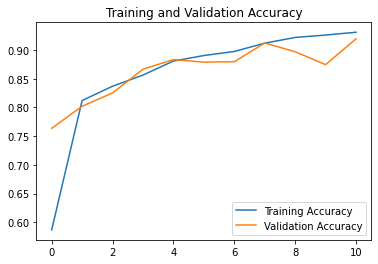

In [24]:
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

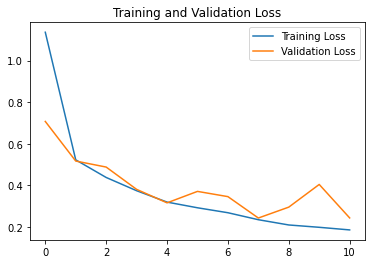

In [25]:
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
!cp "/content/model_natural_images.h5" "/content/drive/MyDrive"

In [22]:
class_names

['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']

40960/33865 [====================================] - 0s 1us/step
This image most likely belongs to airplane with a 87.08 percent confidence.


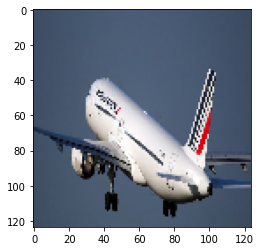

In [29]:
image_url = "https://monroeaerospace.com/blog/wp-content/uploads/2019/01/airplane-1995432_960_720-874x452.jpg"
image_name = image_url.split("/")[-1]
image_path = tf.keras.utils.get_file(image_name, origin=image_url)

img = keras.preprocessing.image.load_img(
    image_path, target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

180224/174762 [==============================] - 0s 0us/step
This image most likely belongs to car with a 63.72 percent confidence.


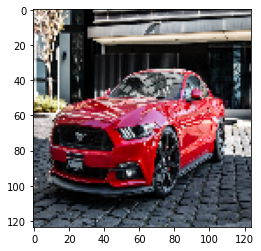

In [30]:
image_url = "https://images.unsplash.com/photo-1597404294360-feeeda04612e?ixid=MnwxMjA3fDB8MHxzZWFyY2h8Mnx8Y2FyfGVufDB8fDB8fA%3D%3D&ixlib=rb-1.2.1&w=1000&q=80"
image_name = image_url.split("/")[-1]
image_path = tf.keras.utils.get_file(image_name, origin=image_url)

img = keras.preprocessing.image.load_img(
    image_path, target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to dog with a 95.35 percent confidence.


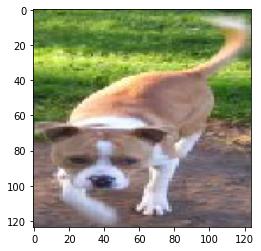

In [34]:
img = keras.preprocessing.image.load_img(
    "/content/data/natural_images/dog/dog_0001.jpg", target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)